In [2]:
import pandas as pd
import plotly.express as px
import matplotlib
from matplotlib import pylab as plt
import datetime
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

In [3]:
cd ..

/home/jovyan/DATA 1030/data1030-project


In [10]:
df = pd.read_csv('data/AB_NYC_2019.csv')

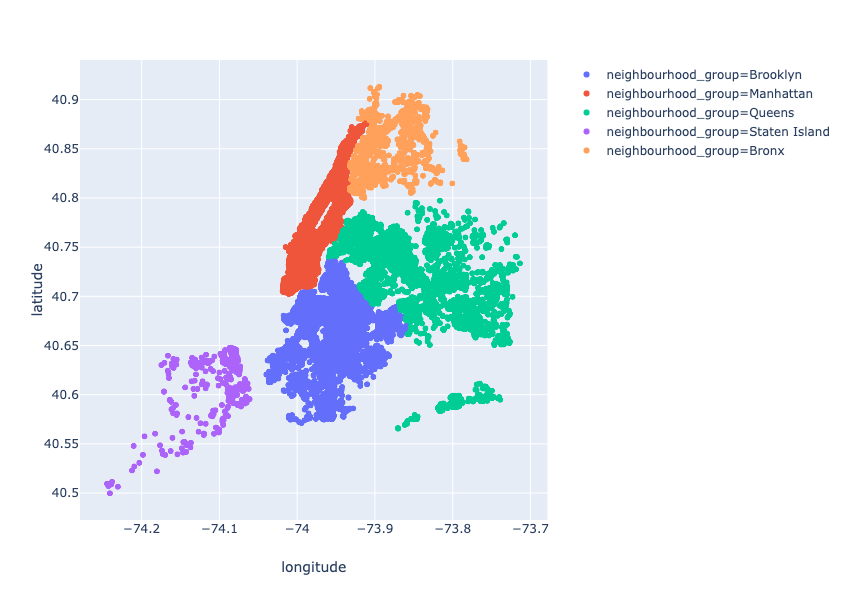

In [10]:
px.scatter(df, x = 'longitude', y = 'latitude', color = 'neighbourhood_group')

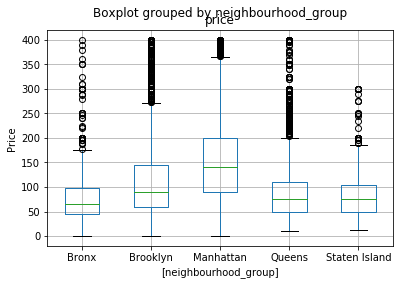

In [13]:
df[df['price'] <= 400][['price', 'neighbourhood_group']].boxplot(by = 'neighbourhood_group')
plt.ylabel('Price')
plt.savefig('figures/region_price.png', dpi = 300)
plt.show()

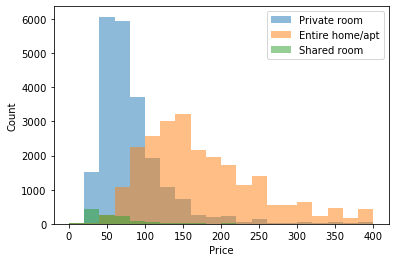

In [12]:
categories = df['room_type'].unique()
bin_range = (df['price'].min(), 400)

for c in categories:
    plt.hist(df[(df['price'] <= 400) & (df['room_type'] == c)]['price'], alpha = 0.5, label = c, 
             range = bin_range, bins = 20)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Price')
plt.savefig('figures/type_price.png', dpi = 300)
plt.show()

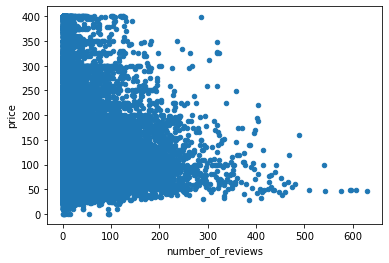

In [86]:
df[df['price'] <= 400].plot.scatter('number_of_reviews', 'price', alpha = 1) 
plt.savefig('figures/review_price.png', dpi = 300)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in log



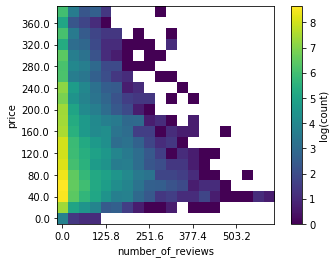

In [5]:
heatmap, xedges, yedges = np.histogram2d(df['number_of_reviews'][df['price'] <= 400], df['price'][df['price'] <= 400], bins=20)

plt.imshow(np.log(heatmap.T), origin='lower')
plt.xlabel('number_of_reviews')
plt.ylabel('price')
plt.xticks(np.arange(20)[::4],xedges[::4])
plt.yticks(np.arange(20)[::2],yedges[::2])
plt.colorbar(label='log(count)')
plt.savefig('figures/review_price.png',dpi=300)
plt.show()

In [11]:
df.drop(columns = ['id', 'host_id'], inplace = True)

ref_date = datetime.datetime(2019, 7, 9, 0, 0)
df.loc[df['number_of_reviews'] == 0, 'last_review'] = '2019-7-9'
review_dates = np.array([datetime.datetime.strptime(str(i), "%Y-%m-%d") for i in df['last_review']])
diff = review_dates - ref_date
days_diff = [i.days for i in diff]
df['last_review'] = days_diff

df.loc[df['number_of_reviews'] == 0, 'reviews_per_month'] = 0

name_len = [len(str(i)) for i in df['name']]
exclamation = [int("!" in str(i)) for i in df['name']]
df['name'] = name_len
df['exclamation'] = exclamation

host_name_len = [int(len(str(i)) >= 3) for i in df['host_name']]
df['host_name'] = host_name_len

In [12]:
onehot = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
minmax = MinMaxScaler()
standard = StandardScaler()

onehot_col = ['neighbourhood_group', 'neighbourhood']
df_onehot = onehot.fit_transform(df[onehot_col])
df1 = pd.DataFrame(df_onehot, columns = onehot.get_feature_names(onehot_col))

ordinal = OrdinalEncoder(categories = [['Shared room', 'Private room', 'Entire home/apt']])
df_ordinal = ordinal.fit_transform(df[['room_type']])
df2 = pd.DataFrame(df_ordinal, columns = ['room_type'])

minmax_col = ['latitude', 'longitude', 'availability_365']
df_minmax = minmax.fit_transform(df[minmax_col])
df3 = pd.DataFrame(df_minmax, columns = minmax_col)

standard_col = ['name', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 
                'calculated_host_listings_count']
df_standard = standard.fit_transform(df[standard_col])
df4 = pd.DataFrame(df_standard, columns = standard_col)

Airbnb = pd.concat([df1, df2, df3, df4, df[['exclamation', 'host_name', 'price']]], axis = 1) # the preprocessed data

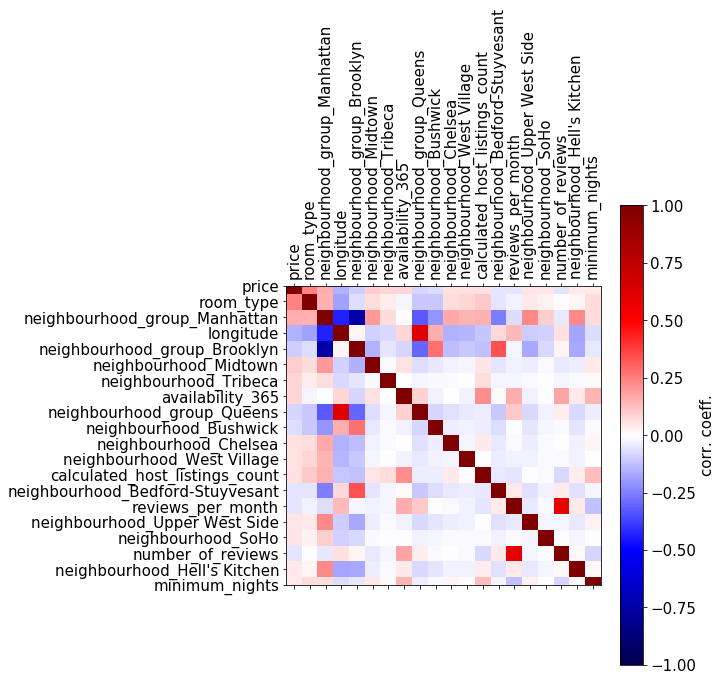

In [37]:
corrmat = Airbnb.corr()

# use the absolute value of the correlation matrix for sorting!
all_cols = np.abs(corrmat).sort_values('price',ascending=False)['price'].index 
cols = all_cols[:20] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
plt.savefig('figures/abs_corr_coeff.png',dpi=300)
plt.show()

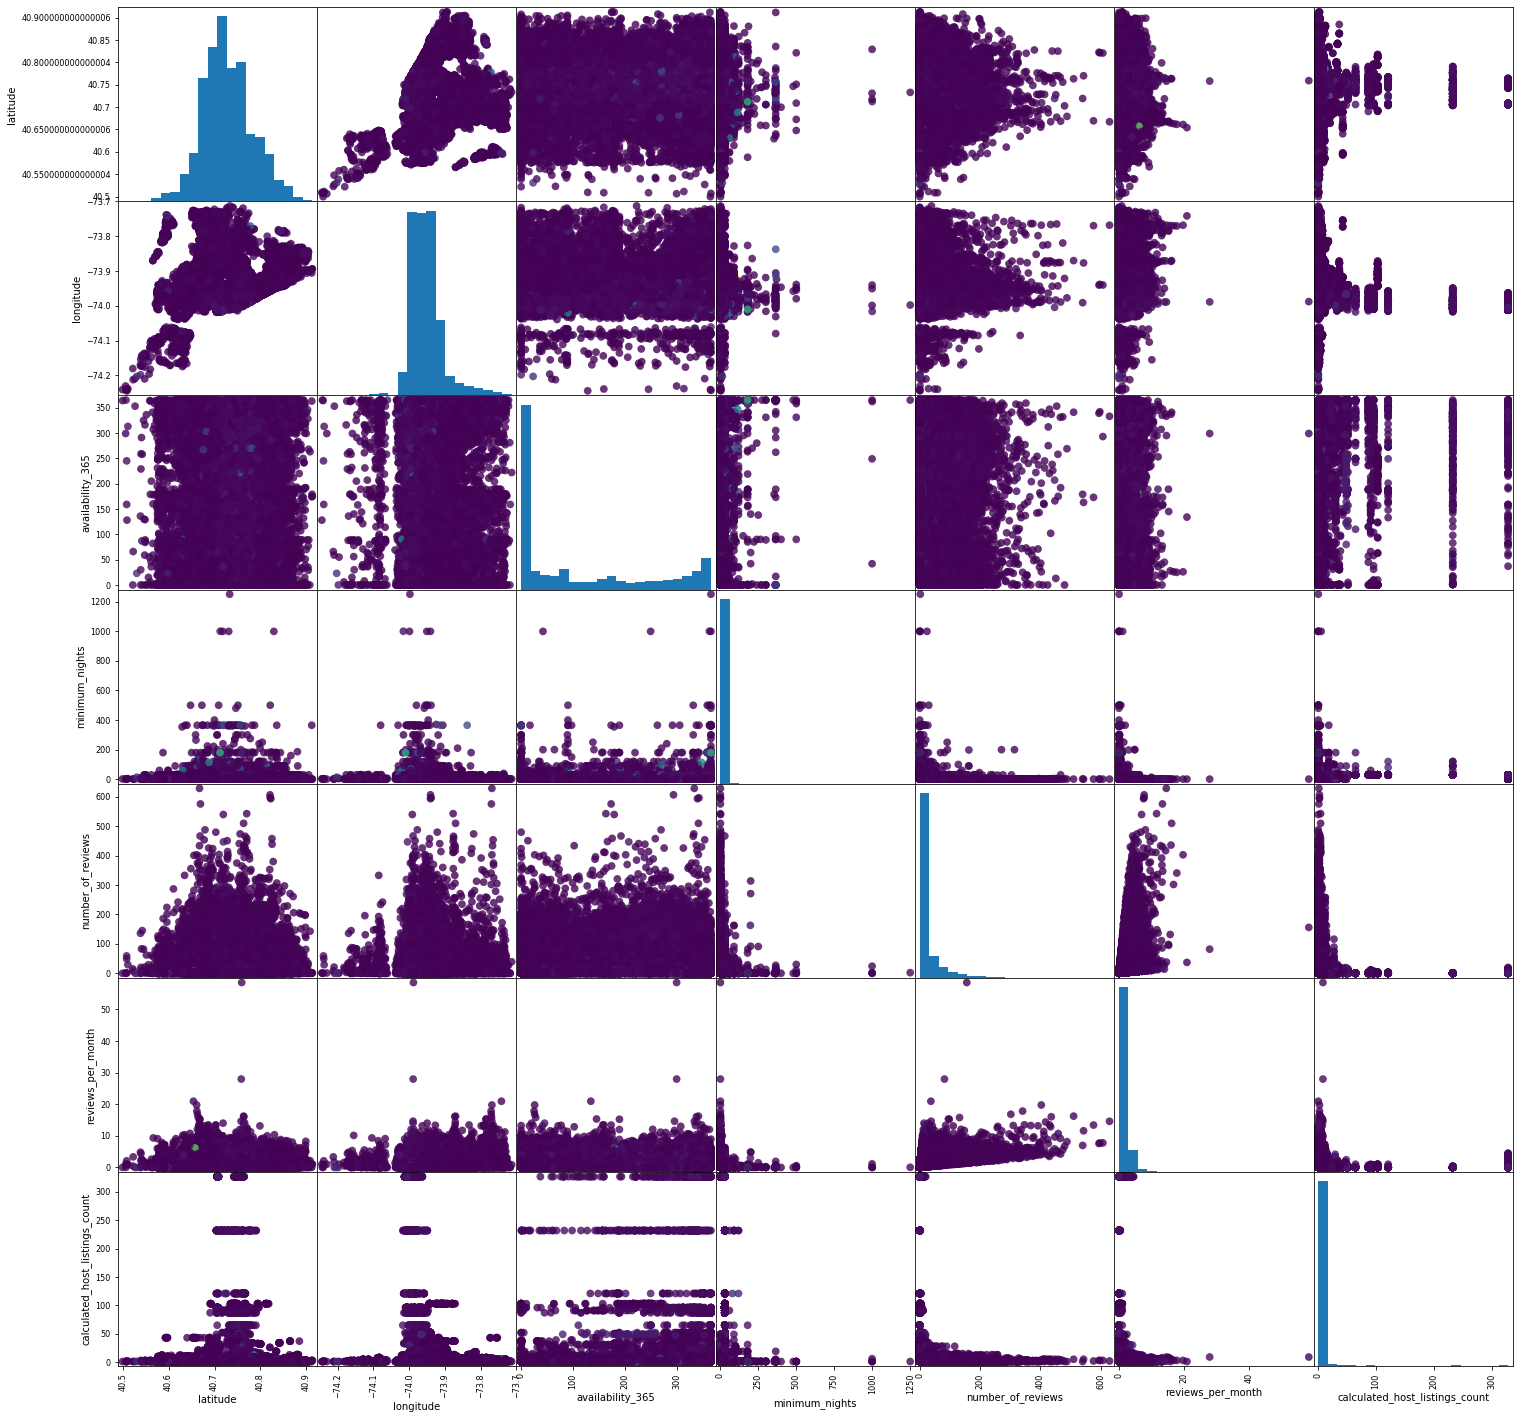

In [20]:
cont_ftrs = ['latitude', 'longitude', 'availability_365', 'minimum_nights', 'number_of_reviews', 
             'reviews_per_month', 'calculated_host_listings_count']
pd.plotting.scatter_matrix(df[cont_ftrs], c = Airbnb['price'], figsize = (25, 25), marker = 'o',
                           hist_kwds = {'bins': 20}, s = 60, alpha = .8)
plt.savefig('figures/scatter_matrix_conts.png', dpi = 300)
plt.show()